In [1]:
import sys
sys.path.append("..")
from dataset.dataloader import MyOcrDataloader, MyCustomOcrDataloader, OCRDataAugmentor
import pandas as pd
import math
import random
import torch
import yaml
import wandb
import os
from PIL import Image
from transformers import TrOCRProcessor, VisionEncoderDecoderModel
import gc
from utils.utils import *
from utils.charactertokenizer import CharacterTokenizer
from jiwer import wer, cer
from models.models import TrOCRMyDecoder
from models.vit import ViT

from tqdm.auto import tqdm
from transformers import AutoTokenizer
from transformers import PreTrainedTokenizerFast

import json

/home/ubuntu/datagen/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


config {'SCENARIO': 1, 'USE_WANDB': True, 'TRAIN_TASK': 'SYNTHETIC', 'HANDWRITTEN_TRAIN_PATH': '/home/ubuntu/data/handwritten_labels/train.csv', 'HANDWRITTEN_VAL_PATH': '/home/ubuntu/data/handwritten_labels/test.csv', 'HANDWRITTEN_IMG_ROOT': '/home/ubuntu/data/handwritten_data', 'TYPED_TRAIN_PATH': '/home/ubuntu/data/typed_labels/train.csv', 'TYPED_VAL_PATH': '/home/ubuntu/data/typed_labels/test.csv', 'TYPED_IMG_ROOT': '/home/ubuntu/data/typed_data', 'SYNTHETIC_TRAIN_PATH': '/home/ubuntu/data/synthetic_data/labels/output_labels_train.csv', 'SYNTHETIC_VAL_PATH': '/home/ubuntu/data/synthetic_data/labels/output_labels_test.csv', 'SYNTHETIC_IMG_ROOT': '/home/ubuntu/data/synthetic_data/data', 'BATCH_SIZE': 64, 'MODEL_ID': 'microsoft/trocr-base-handwritten', 'EPOCHS': 100, 'enc_dropout': 0.2, 'enc_num_layers': 1, 'enc_num_heads': 1, 'dec_dropout': 0.2, 'dec_num_layers': 6, 'dec_num_heads': 8, 'd_model': 256, 'd_ff': 1024, 'learning_rate': '5E-5', 'optimizer': 'AdamW', 'momentum': 0.0, 'neste

In [4]:
# encoder = ViT(image_size = (256, 1024), num_classes= None, mlp_dim=1024, patch_size=32, dim=512, depth= 4, heads = 4 )
# img = torch.randn(1, 3, 256, 1024)

# preds = encoder(img) # (1, 1000)
# preds.shape

In [5]:
config_path = os.path.join(os.path.abspath(os.path.join(os.getcwd(), '..')), "config/main.yaml")
with open(config_path, "r") as file:
    config = yaml.safe_load(file)
task  = config["TRAIN_TASK"]
os.environ["TOKENIZERS_PARALLELISM"] = "false"

TRAIN_PATH =config[task+"_"+"TRAIN_PATH"]
VAL_PATH =config[task+"_"+"VAL_PATH"]
IMG_ROOT = config[task+"_"+"IMG_ROOT"]

MODEL_ID = config["MODEL_ID"]

device = "cuda" if torch.cuda.is_available() else "cpu"
processor = resize_and_patch_image
# model =VisionEncoderDecoderModel.from_pretrained(MODEL_ID).to(device)
# model.config.decoder_start_token_id = processor.tokenizer.eos_token_id
# model.config.pad_token_id = processor.tokenizer.pad_token_id
# model.config.vocab_size = model.config.decoder.vocab_size

In [6]:

# tokenizer = AutoTokenizer.from_pretrained("rasyosef/bert-amharic-tokenizer")
# tokenizer.tokenize("የዓለምአቀፉ ነጻ ንግድ መስፋፋት ድህነትን ለማሸነፍ በሚደረገው ትግል አንዱ ጠቃሚ መሣሪያ ሊሆን መቻሉ ብዙ የሚነገርለት ጉዳይ ነው።")
# tokenizer.vocab_size

In [7]:
## sanity check for data loader
os.chdir("../dataset")
augmentor = OCRDataAugmentor()
# tokenizer = CharacterTokenizer.from_pretrained('/home/ubuntu/HandWritten_Amharic_English_OCR/Amharic_Char_Tokenizer2')
tokenizer = PreTrainedTokenizerFast.from_pretrained("/home/ubuntu/data/synthetic_data/amharic_tokenizer_hf")

# tokenizer = AutoTokenizer.from_pretrained("rasyosef/bert-amharic-tokenizer")

if tokenizer.bos_token_id== None:
    print("setting tokenizer")
    special_tokens_dict = {
    "bos_token": "<sos>",
    "eos_token": "<eos>"
    }
    tokenizer.add_special_tokens(special_tokens_dict)

train_data = MyCustomOcrDataloader(TRAIN_PATH, preprocessor=processor, tokenizer  = tokenizer, img_root=IMG_ROOT, transform=augmentor)
val_data = MyCustomOcrDataloader(VAL_PATH, preprocessor=processor, tokenizer  = tokenizer, img_root=IMG_ROOT)
train_loader = torch.utils.data.DataLoader(
    dataset     = train_data,
    batch_size  = config['BATCH_SIZE'],
    shuffle     = True,
    collate_fn= train_data.collate_fn
    )



setting tokenizer


In [8]:

train_loader    = torch.utils.data.DataLoader(
    dataset     = train_data,
    batch_size  = config["BATCH_SIZE"],
    shuffle     = True,
    num_workers = 4,
    pin_memory  = True,
    collate_fn  = train_data.collate_fn
)

val_loader      = torch.utils.data.DataLoader(
    dataset     = val_data,
    batch_size  = config["BATCH_SIZE"],
    shuffle     = False,
    num_workers = 2,
    pin_memory  = True,
    collate_fn  = train_data.collate_fn,
)

print("No. of Train Images   : ", train_data.__len__())
print("Batch Size           : ", config["BATCH_SIZE"])
print("Train Batches        : ", train_loader.__len__())
print("Val Batches          : ", val_loader.__len__())

No. of Train Images   :  10000
Batch Size           :  64
Train Batches        :  157
Val Batches          :  157


Checking the Shapes of the Data --

x_pad shape:		torch.Size([64, 1, 3, 256, 1024])
x_len shape:		torch.Size([64])

y_shifted_pad shape:	torch.Size([64, 33])
y_golden_pad shape:	torch.Size([64, 33])
y_len shape:		torch.Size([64])



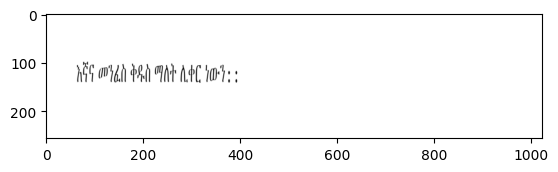

In [9]:
''' Sanity Check '''

print("Checking the Shapes of the Data --\n")

for batch in train_loader:
    x_pad, y_shifted_pad, y_golden_pad, x_len, y_len, = batch

    print(f"x_pad shape:\t\t{x_pad.shape}")
    print(f"x_len shape:\t\t{x_len.shape}\n")

    print(f"y_shifted_pad shape:\t{y_shifted_pad.shape}")
    print(f"y_golden_pad shape:\t{y_golden_pad.shape}")
    print(f"y_len shape:\t\t{y_len.shape}\n")
    plt.imshow(x_pad[0][0].permute((1,2,0)))
    # print(y_shifted_pad)

    break

In [10]:
''' Please refer to the config file and top sections to fill in the following '''

model = TrOCRMyDecoder(
input_dim                   = None,
dec_num_layers              = config["dec_num_layers"],
dec_num_heads               = config["dec_num_heads"],

d_model                     = config["d_model"],
d_ff                        = config["d_ff"],

target_vocab_size           = len(tokenizer),
eos_token                   = tokenizer.eos_token_id,
sos_token                   = tokenizer.bos_token_id,
pad_token                   = tokenizer.pad_token_id,

enc_dropout                 = config["enc_dropout"],
dec_dropout                 = config["enc_dropout"],

# decrease to a small number if you are just trying to implement the network
max_seq_length              = 512 , # Max sequence length for transcripts. Check data verification.
).to(device)

def num_parameters(mode):
    total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return total_params / 1E6

para = num_parameters(model)
print("#"*10)
print(f"Model Parameters:\n {para}")
print("#"*10)

##########
Model Parameters:
 30.89101
##########


In [11]:
def train_model(model, train_loader, optimizer):

    model.train()
    batch_bar = tqdm(total=len(train_loader), dynamic_ncols=True, leave=False, position=0, desc="Train")

    total_loss          = 0
    running_loss        = 0.0
    running_perplexity  = 0.0

    for i, (inputs, targets_shifted, targets_golden, inputs_lengths, targets_lengths) in enumerate(train_loader):

        optimizer.zero_grad()

        inputs          = inputs.to(device)
        targets_shifted = targets_shifted.to(device)
        targets_golden  = targets_golden.to(device)

        with torch.cuda.amp.autocast():
            # passing the minibatch through the model
            # raw_predictions, attention_weights = model(inputs, inputs_lengths, targets_shifted, targets_lengths)
            raw_predictions, attention_weights = model(inputs, inputs_lengths, targets_shifted, targets_lengths)


            padding_mask = torch.logical_not(torch.eq(targets_shifted, tokenizer.pad_token_id))

            # cast the mask to float32
            padding_mask = padding_mask.float()
            loss = loss_func(raw_predictions.transpose(1,2), targets_golden)*padding_mask
            loss = loss.sum() / padding_mask.sum()

        scaler.scale(loss).backward()   # This is a replacement for loss.backward()
        scaler.step(optimizer)          # This is a replacement for optimizer.step()
        scaler.update()                 # This is something added just for FP16

        running_loss        += float(loss.item())
        perplexity          = torch.exp(loss)
        running_perplexity  += perplexity.item()

        # online training monitoring
        batch_bar.set_postfix(
            loss = "{:.04f}".format(float(running_loss / (i + 1))),
            perplexity = "{:.04f}".format(float(running_perplexity / (i + 1)))
        )

        batch_bar.update()

        del inputs, targets_shifted, targets_golden, inputs_lengths, targets_lengths
        torch.cuda.empty_cache()

    running_loss        = float(running_loss / len(train_loader))
    running_perplexity  = float(running_perplexity / len(train_loader))

    batch_bar.close()

    return running_loss, running_perplexity, attention_weights

In [12]:
def validate_fast(model, dataloader):
    model.eval()

    # progress bar
    batch_bar = tqdm(total=len(dataloader), dynamic_ncols=True, leave=False, position=0, desc="Val", ncols=5)

    running_distance = 0.0
    running_cer = 0.0
    running_wer = 0.0
    running_char_f1 = 0.0
    running_word_f1 = 0.0


    for i, (inputs, targets_shifted, targets_golden, inputs_lengths, targets_lengths) in enumerate(dataloader):

        inputs  = inputs.to(device)
        targets_golden = targets_golden.to(device)

        with torch.inference_mode():
            greedy_predictions = model.recognize(inputs, inputs_lengths)

        # calculating Levenshtein Distance
        # @NOTE: modify the print_example to print more or less validation examples
        dist, cer, wer, charf1, word_f1 = calc_edit_distance(greedy_predictions, targets_golden, targets_lengths, tokenizer, print_example=True)
        running_distance += dist
        running_cer += cer
        running_wer += wer
        running_char_f1 += charf1
        running_word_f1 += word_f1


        # online validation distance monitoring
        batch_bar.set_postfix(
            running_distance = "{:.04f}".format(float(running_distance / (i + 1))),
            running_cer = "{:.04f}".format(float(running_cer / (i + 1))),
            running_wer = "{:.04f}".format(float(running_wer / (i + 1))),
            running_char_f1 = "{:.04f}".format(float(running_char_f1 / (i + 1))),
            running_word_f1 = "{:.04f}".format(float(running_word_f1 / (i + 1)))

        )

        batch_bar.update()

        del inputs, targets_shifted, targets_golden, inputs_lengths, targets_lengths
        torch.cuda.empty_cache()

        if i==4: break      # validating only upon first five batches

    batch_bar.close()
    running_distance /= 5
    running_cer /= 5
    running_wer /= 5
    running_char_f1 /= 5
    running_word_f1 /= 5

    return running_distance, running_cer, running_wer, running_char_f1, running_word_f1

def validate_full(model, dataloader):
    model.eval()

    # progress bar
    batch_bar = tqdm(total=len(dataloader), dynamic_ncols=True, leave=False, position=0, desc="Val", ncols=5)

    running_distance = 0.0
    running_cer = 0.0
    running_wer = 0.0
    running_char_f1 = 0.0
    running_word_f1 =0.0

    for i, (inputs, targets_shifted, targets_golden, inputs_lengths, targets_lengths) in enumerate(dataloader):

        inputs  = inputs.to(device)
        targets_golden = targets_golden.to(device)

        with torch.inference_mode():
            greedy_predictions = model.recognize(inputs, inputs_lengths)

        # calculating Levenshtein Distance
        # @NOTE: modify the print_example to print more or less validation examples
        dist, cer, wer, charf1, word_f1 = calc_edit_distance(greedy_predictions, targets_golden, targets_lengths, tokenizer, print_example=False)
        running_distance += dist
        running_cer += cer
        running_wer += wer
        running_char_f1 += charf1
        running_word_f1 += word_f1


        # online validation distance monitoring
        batch_bar.set_postfix(
            running_distance = "{:.04f}".format(float(running_distance / (i + 1))),
            running_cer = "{:.04f}".format(float(running_cer / (i + 1))),
            running_wer = "{:.04f}".format(float(running_wer / (i + 1))),
            running_char_f1 = "{:.04f}".format(float(running_char_f1 / (i + 1))),
            running_word_f1 = "{:.04f}".format(float(running_word_f1 / (i + 1)))

        )
        batch_bar.update()

        del inputs, targets_shifted, targets_golden, inputs_lengths, targets_lengths
        torch.cuda.empty_cache()


    batch_bar.close()
    running_distance /= len(dataloader)
    running_cer /= len(dataloader)
    running_wer /= len(dataloader)
    running_char_f1 /= len(dataloader)
    running_word_f1 /= len(dataloader)


    return running_distance, running_cer, running_wer, running_char_f1, running_word_f1

In [13]:
''' defining optimizer '''
# vocab_size = len(tokenizer)
# weights = torch.ones(vocab_size).to("cuda")  # default weight = 1 for all
# whitespace_token_id = tokenizer.convert_tokens_to_ids(tokenizer.tokenize(' ')[0])
# # Decrease weight for whitespace token
# weights[whitespace_token_id] = 0.1  # e.g., reduce impact by 90%
loss_func   = torch.nn.CrossEntropyLoss(ignore_index = tokenizer.pad_token_id)
scaler      = torch.cuda.amp.GradScaler()
if config["optimizer"] == "SGD":
  # feel free to change any of the initializations you like to fit your needs
  optimizer = torch.optim.SGD(model.parameters(),
                              lr=config["learning_rate"],
                              momentum=config["momentum"],
                              weight_decay=1E-4,
                              nesterov=config["nesterov"])

elif config["optimizer"] == "Adam":
  # feel free to change any of the initializations you like to fit your needs
  optimizer = torch.optim.Adam(model.parameters(),
                               lr=float(config["learning_rate"]),
                               weight_decay=1e-4)

elif config["optimizer"] == "AdamW":
  # feel free to change any of the initializations you like to fit your needs
  optimizer = torch.optim.AdamW(model.parameters(),
                                lr=float(config["learning_rate"]),
                                weight_decay=0.01)

''' defining scheduler '''

if config["scheduler"] == "ReduceLR":
  #Feel Free to change any of the initializations you like to fit your needs
  scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                factor=config["factor"], patience=config["patience"], min_lr=1E-8, verbose=True)

elif config["scheduler"] == "CosineAnnealing":
  #Feel Free to change any of the initializations you like to fit your needs
  scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer,
                T_max = 35, eta_min=1E-8)

/tmp/ipykernel_723648/1907291034.py:8: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler      = torch.cuda.amp.GradScaler()


In [14]:
device

'cuda'

In [15]:
# using WandB? resume training?

USE_WANDB = config["USE_WANDB"]
RESUME_LOGGING = False

# creating your WandB run
run_name = "{}_Transformer_ENC-{}/{}_DEC-{}/{}_{}_{}_{}_{}".format(
    config["Name"],
    config["enc_num_layers"],       # only used in Part II with the Transformer Encoder
    config["enc_num_heads"],        # only used in Part II with the Transformer Encoder
    config["dec_num_layers"],
    config["dec_num_heads"],
    config["d_model"],
    config["d_ff"],
    config["optimizer"],
    config["scheduler"])
task = "handonly"

if USE_WANDB:

    wandb.login(key="3c7b273814544590b64c54d9a5242bde38616e02", relogin=True) # TODO enter your key here

    if RESUME_LOGGING:
        run_id = ""
        run = wandb.init(
            id     = run_id,        ### Insert specific run id here if you want to resume a previous run
            resume = True,          ### You need this to resume previous runs, but comment out reinit=True when using this
            project = task+"ocr-cnn-lstm",  ### Project should be created in your wandb account
        )

    else:
        run = wandb.init(
            name    = run_name,     ### Wandb creates random run names if you skip this field, we recommend you give useful names
            reinit  = True,         ### Allows reinitalizing runs when you re-run this cell
            project = task+"ocr-cnn-lstm",  ### Project should be created in your wandb account
            config  = config        ### Wandb Config for your run
        )

        ### Save your model architecture as a string with str(model)
        model_arch  = str(model)

        ### Save it in a txt file
        arch_file   = open("model_arch.txt", "w")
        file_write  = arch_file.write(model_arch)
        arch_file.close()

        ### Log it in your wandb run with wandb.save()
        # wandb.save("model_arch.txt")

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /home/ubuntu/.netrc
wandb: Currently logged in as: blessedg (idls24) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: WARNING Using a boolean value for 'reinit' is deprecated. Use 'return_previous' or 'finish_previous' instead.


In [16]:
e                   = 0
best_loss           = 0
best_distance  = 0
checkpoint_root = os.path.join(os.getcwd(), "checkpoints-basic-cnn-transformer")
os.makedirs(checkpoint_root, exist_ok=True)
if USE_WANDB:
    wandb.watch(model, log="all")
task =  config["TRAIN_TASK"]
checkpoint_best_loss_model_filename     = task +'checkpoint-best-loss-model.pth' 
checkpoint_best_distance_model_filename     = task +'checkpoint-best-distance-model.pth'

checkpoint_last_epoch_filename          = 'checkpoint-epoch-'
best_loss_model_path                    = os.path.join(checkpoint_root, checkpoint_best_loss_model_filename)
best_distance_model_path                    = os.path.join(checkpoint_root, checkpoint_best_distance_model_filename)


if RESUME_LOGGING:
    # change if you want to load best test model accordingly
    checkpoint = torch.load(wandb.restore(checkpoint_best_loss_model_filename, run_path=""+run_id).name)

    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    e = checkpoint['epoch']

    print("Resuming from epoch {}".format(e+1))
    print("Epochs left: ", config['epochs']-e)
    print("Optimizer: \n", optimizer)

torch.cuda.empty_cache()
gc.collect()

epochs = config["epochs"]
for epoch in range(e, epochs):

    print("\nEpoch {}/{}".format(epoch+1, config["epochs"]))

    curr_lr = float(optimizer.param_groups[0]["lr"])

    train_loss, train_perplexity, attention_weights = train_model(model, train_loader, optimizer)

    print("\nEpoch {}/{}: \nTrain Loss {:.04f}\t Train Perplexity {:.04f}\t Learning Rate {:.04f}".format(
        epoch + 1, config["epochs"], train_loss, train_perplexity, curr_lr))

    if (epoch >1 )and (epoch % 10 == 0):    # validate every 2 epochs to speed up training
        levenshtein_distance, cer, wer, charf1, wordf1 = validate_fast(model, val_loader)
        if best_distance <= levenshtein_distance:
            best_distance = levenshtein_distance
            save_model(model, optimizer, scheduler, ['val_distance', levenshtein_distance], epoch, best_distance_model_path)
            # wandb.save(best_loss_model_path)
            print("Saved distance training model")
        print("Levenshtein Distance {:.04f}".format(levenshtein_distance))
        if USE_WANDB:
            wandb.log({"train_loss"     : train_loss,
                    "train_perplexity"  : train_perplexity,
                    "learning_rate"     : curr_lr,
                    "val_distance"      : levenshtein_distance,
                    "charf1": charf1,
                    "wordf1": wordf1,})

    else:
        if USE_WANDB:

            wandb.log({"train_loss"     : train_loss,
                    "train_perplexity"  : train_perplexity,
                    "learning_rate"     : curr_lr})

    # # plotting the encoder-nearest and decoder-nearest attention weights
    # attention_keys = list(attention_weights.keys())

    # attention_weights_decoder_self       = attention_weights[attention_keys[0]][0].cpu().detach().numpy()
    # attention_weights_decoder_cross      = attention_weights[attention_keys[-1]][0].cpu().detach().numpy()

    # # saving the cross-attention weights
    # save_attention_plot(attention_weights_decoder_cross, epoch+100)

    # plot_attention_weights((attention_weights[attention_keys[0]][0]).cpu().detach().numpy())
    # plot_attention_weights(attention_weights[attention_keys[-1]][0].cpu().detach().numpy())

    # if config["scheduler"] == "ReduceLR":
    #     scheduler.step(levenshtein_distance)
    # else:
    #     scheduler.step()

    # ### Highly Recommended: Save checkpoint in drive and/or wandb if accuracy is better than your current best
    # epoch_model_path = os.path.join(checkpoint_root, (checkpoint_last_epoch_filename + str(epoch) + '.pth'))
    # save_model(model, optimizer, scheduler, ['train_loss', train_loss], epoch, epoch_model_path)
    ## wandb.save(epoch_model_path) ## Can't save on wandb for all epochs, may blow up storage


    if best_loss >= train_loss:
        best_loss = train_loss
        save_model(model, optimizer, scheduler, ['train_loss', train_loss], epoch, best_loss_model_path)
        # wandb.save(best_loss_model_path)
        print("Saved best training model")

### Finish your wandb run
# run.finish()


Epoch 1/50


Train:   0%|          | 0/157 [00:00<?, ?it/s]/tmp/ipykernel_723648/3134595652.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():



Epoch 1/50: 
Train Loss 9.7843	 Train Perplexity 18618.4882	 Learning Rate 0.0001

Epoch 2/50



Epoch 2/50: 
Train Loss 8.9782	 Train Perplexity 7997.9891	 Learning Rate 0.0001

Epoch 3/50



Epoch 3/50: 
Train Loss 8.7003	 Train Perplexity 6012.8503	 Learning Rate 0.0001

Epoch 4/50



Epoch 4/50: 
Train Loss 8.6470	 Train Perplexity 5701.7316	 Learning Rate 0.0001

Epoch 5/50



Epoch 5/50: 
Train Loss 8.6150	 Train Perplexity 5520.4645	 Learning Rate 0.0001

Epoch 6/50



Epoch 6/50: 
Train Loss 8.5877	 Train Perplexity 5373.3749	 Learning Rate 0.0001

Epoch 7/50



Epoch 7/50: 
Train Loss 8.5688	 Train Perplexity 5272.0441	 Learning Rate 0.0001

Epoch 8/50



Epoch 8/50: 
Train Loss 8.5549	 Train Perplexity 5197.8645	 Learning Rate 0.0001

Epoch 9/50



Epoch 9/50: 
Train Loss 8.5415	 Train Perplexity 5128.9682	 Learning Rate 0.0001

Epoch 10/50



Epoch 10/50: 
Train Loss 8.5283	 Train Perplexity 5062.5420	 Learning Rate 0.0001

Epoch 11/50



Epoch 11/50: 
Train Loss 8.5172	 Train Perplexity 5007.7997	 Learning Rate 0.0001


Val:   1%|          | 1/157 [00:23<1:01:48, 23.78s/it, running_cer=0.8787, running_char_f1=0.0919, running_distance=59.9375, running_wer=1.2971, running_word_f1=0.0072]


Ground Truth :  የፌዴራሉ ከፍተኛ ፍርድ ቤት የነ ዘላለም ወርቅ አገኘ ሁን ፍርድ ለሌላ ጊዜ አስተላለፈ
Prediction   :  ላይ ላይ ላይ ላይ ላይ ላይ ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው


Val:   1%|▏         | 2/157 [00:45<58:40, 22.72s/it, running_cer=0.8656, running_char_f1=0.0926, running_distance=60.7812, running_wer=1.2821, running_word_f1=0.0103]  


Ground Truth :  አንድ ኩባ ያ ም ስር የፎ ሌት ፍላ ታችንን ያ ሟ ላል
Prediction   :  ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው


Val:   2%|▏         | 3/157 [01:07<57:29, 22.40s/it, running_cer=0.8785, running_char_f1=0.0937, running_distance=60.8802, running_wer=1.3099, running_word_f1=0.0093]


Ground Truth :  እሳቸው ከሥልጣን አል ወር ድም ብለው ከኢህአዴግ ጋር ሙግት ሊ ገጥ ሙ አይችሉም ይሄ ማ ውለታ ቢስ መሆን ነው እናላችሁ ሰላማዊ የስልጣን ሽግግር ከሚለው ይልቅ
Prediction   :  ላይ ላይ ላይ ላይ ላይ ላይ ላይ ላይ ላይ ላይ ላይ ላይ ላይ ላይ ላይ ላይ ላይ ላይ ላይ ላይ ላይ ነው


Val:   3%|▎         | 4/157 [01:29<56:40, 22.22s/it, running_cer=0.8881, running_char_f1=0.0897, running_distance=60.7695, running_wer=1.3047, running_word_f1=0.0116]


Ground Truth :  ተስፋ መፈን ጠቅ በጀመረ በት ወቅት የሚካሄድ መሆኑን በማረጋገጥ ለውጡን በብቃት ለመምራት በሚያስ ችሉ የ ድርጅትና የመንግስት ሪፎርም ጉዳዮች ዙሪያ በስፋት ተወያይቶ ውሳኔዎች አሳልፏል
Prediction   :  ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና


Val:   3%|▎         | 5/157 [01:51<56:01, 22.11s/it, running_cer=0.8788, running_char_f1=0.0901, running_distance=61.4000, running_wer=1.2765, running_word_f1=0.0122]


Ground Truth :  የኢትዮጵያ የምርጫ ቅርጫ አይን ያወጣ የቅ ጥፈት የይስሙላ ምርጫ ፕሮፌሰር አለማየሁ ገብረማርያም
Prediction   :  ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው


Saved distance training model
Levenshtein Distance 61.4000

Epoch 12/50


Train:   0%|          | 0/157 [00:00<?, ?it/s]/tmp/ipykernel_723648/3134595652.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():



Epoch 12/50: 
Train Loss 8.5035	 Train Perplexity 4938.3547	 Learning Rate 0.0001

Epoch 13/50



Epoch 13/50: 
Train Loss 8.4880	 Train Perplexity 4864.0745	 Learning Rate 0.0001

Epoch 14/50



Epoch 14/50: 
Train Loss 8.4713	 Train Perplexity 4784.5364	 Learning Rate 0.0001

Epoch 15/50



Epoch 15/50: 
Train Loss 8.4563	 Train Perplexity 4711.7348	 Learning Rate 0.0001

Epoch 16/50



Epoch 16/50: 
Train Loss 8.4388	 Train Perplexity 4629.2968	 Learning Rate 0.0001

Epoch 17/50



Epoch 17/50: 
Train Loss 8.4225	 Train Perplexity 4553.9536	 Learning Rate 0.0001

Epoch 18/50



Epoch 18/50: 
Train Loss 8.4009	 Train Perplexity 4458.9761	 Learning Rate 0.0001

Epoch 19/50



Epoch 19/50: 
Train Loss 8.3866	 Train Perplexity 4394.1271	 Learning Rate 0.0001

Epoch 20/50



Epoch 20/50: 
Train Loss 8.3683	 Train Perplexity 4314.6737	 Learning Rate 0.0001

Epoch 21/50



Epoch 21/50: 
Train Loss 8.3503	 Train Perplexity 4237.2750	 Learning Rate 0.0001


Val:   1%|          | 1/157 [00:23<1:01:30, 23.66s/it, running_cer=7.4763, running_char_f1=0.1007, running_distance=687.3906, running_wer=11.1243, running_word_f1=0.0033]


Ground Truth :  የፌዴራሉ ከፍተኛ ፍርድ ቤት የነ ዘላለም ወርቅ አገኘ ሁን ፍርድ ለሌላ ጊዜ አስተላለፈ
Prediction   :  ላይ ላይ ላይ ላይ ላይ ላይ ላይ ላይ ላይ ላይ ላይ ላይ ላይ ላይ ላይ ላይ ላይ ነው


Val:   1%|▏         | 2/157 [00:45<58:40, 22.71s/it, running_cer=7.9855, running_char_f1=0.0984, running_distance=721.8984, running_wer=11.6338, running_word_f1=0.0070]  


Ground Truth :  አንድ ኩባ ያ ም ስር የፎ ሌት ፍላ ታችንን ያ ሟ ላል
Prediction   :  በ በ በ በ በ በ በ በ በ በ ላይ ላይ ላይ ላይ ላይ ላይ ላይ ነው


Val:   2%|▏         | 3/157 [01:07<57:32, 22.42s/it, running_cer=7.8865, running_char_f1=0.0978, running_distance=711.6458, running_wer=11.5977, running_word_f1=0.0089]


Ground Truth :  እሳቸው ከሥልጣን አል ወር ድም ብለው ከኢህአዴግ ጋር ሙግት ሊ ገጥ ሙ አይችሉም ይሄ ማ ውለታ ቢስ መሆን ነው እናላችሁ ሰላማዊ የስልጣን ሽግግር ከሚለው ይልቅ
Prediction   :  ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ላይ ላይ ላይ ላይ ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው

Val:   3%|▎         | 4/157 [01:29<56:42, 22.24s/it, running_cer=7.8136, running_char_f1=0.0950, running_distance=703.4180, running_wer=11.4046, running_word_f1=0.0083]


Ground Truth :  ተስፋ መፈን ጠቅ በጀመረ በት ወቅት የሚካሄድ መሆኑን በማረጋገጥ ለውጡን በብቃት ለመምራት በሚያስ ችሉ የ ድርጅትና የመንግስት ሪፎርም ጉዳዮች ዙሪያ በስፋት ተወያይቶ ውሳኔዎች አሳልፏል
Prediction   :  ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና


Val:   3%|▎         | 5/157 [01:51<56:03, 22.13s/it, running_cer=7.9243, running_char_f1=0.0938, running_distance=719.4094, running_wer=11.5075, running_word_f1=0.0084]


Ground Truth :  የኢትዮጵያ የምርጫ ቅርጫ አይን ያወጣ የቅ ጥፈት የይስሙላ ምርጫ ፕሮፌሰር አለማየሁ ገብረማርያም
Prediction   :  ላይ ላይ ላይ ላይ ላይ ላይ ላይ ላይ ላይ ላይ ላይ ላይ ላይ ላይ ላይ ላይ ላይ ላይ ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው


Saved distance training model
Levenshtein Distance 719.4094

Epoch 22/50


Train:   0%|          | 0/157 [00:00<?, ?it/s]/tmp/ipykernel_723648/3134595652.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():



Epoch 22/50: 
Train Loss 8.3325	 Train Perplexity 4163.4318	 Learning Rate 0.0001

Epoch 23/50



Epoch 23/50: 
Train Loss 8.3175	 Train Perplexity 4099.6091	 Learning Rate 0.0001

Epoch 24/50



Epoch 24/50: 
Train Loss 8.2993	 Train Perplexity 4026.3960	 Learning Rate 0.0001

Epoch 25/50



Epoch 25/50: 
Train Loss 8.2792	 Train Perplexity 3946.1936	 Learning Rate 0.0001

Epoch 26/50



Epoch 26/50: 
Train Loss 8.2638	 Train Perplexity 3887.5140	 Learning Rate 0.0001

Epoch 27/50



Epoch 27/50: 
Train Loss 8.2461	 Train Perplexity 3816.9675	 Learning Rate 0.0001

Epoch 28/50



Epoch 28/50: 
Train Loss 8.2272	 Train Perplexity 3745.9910	 Learning Rate 0.0001

Epoch 29/50



Epoch 29/50: 
Train Loss 8.2072	 Train Perplexity 3673.5812	 Learning Rate 0.0001

Epoch 30/50



Epoch 30/50: 
Train Loss 8.1920	 Train Perplexity 3616.4856	 Learning Rate 0.0001

Epoch 31/50



Epoch 31/50: 
Train Loss 8.1757	 Train Perplexity 3558.4326	 Learning Rate 0.0001


Val:   1%|          | 1/157 [00:23<1:01:38, 23.71s/it, running_cer=14.0718, running_char_f1=0.0965, running_distance=1040.2031, running_wer=23.7411, running_word_f1=0.0021]


Ground Truth :  የፌዴራሉ ከፍተኛ ፍርድ ቤት የነ ዘላለም ወርቅ አገኘ ሁን ፍርድ ለሌላ ጊዜ አስተላለፈ
Prediction   :  በ በ በ በ በ በ ከ ከ ከ ከ ከ ከ ከ ከ ከ ከ ከ ከ ከ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ 

Val:   1%|▏         | 2/157 [00:45<58:32, 22.66s/it, running_cer=14.4737, running_char_f1=0.0998, running_distance=1068.2266, running_wer=23.6961, running_word_f1=0.0079]  


Ground Truth :  አንድ ኩባ ያ ም ስር የፎ ሌት ፍላ ታችንን ያ ሟ ላል
Prediction   :  በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ 

Val:   2%|▏         | 3/157 [01:07<57:24, 22.36s/it, running_cer=14.6824, running_char_f1=0.1015, running_distance=1070.2865, running_wer=24.3629, running_word_f1=0.0079]


Ground Truth :  እሳቸው ከሥልጣን አል ወር ድም ብለው ከኢህአዴግ ጋር ሙግት ሊ ገጥ ሙ አይችሉም ይሄ ማ ውለታ ቢስ መሆን ነው እናላችሁ ሰላማዊ የስልጣን ሽግግር ከሚለው ይልቅ
Prediction   :  ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው

Val:   3%|▎         | 4/157 [01:29<56:36, 22.20s/it, running_cer=14.2296, running_char_f1=0.1022, running_distance=1045.1523, running_wer=23.6270, running_word_f1=0.0095]


Ground Truth :  ተስፋ መፈን ጠቅ በጀመረ በት ወቅት የሚካሄድ መሆኑን በማረጋገጥ ለውጡን በብቃት ለመምራት በሚያስ ችሉ የ ድርጅትና የመንግስት ሪፎርም ጉዳዮች ዙሪያ በስፋት ተወያይቶ ውሳኔዎች አሳልፏል
Prediction   :  ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና 

Val:   3%|▎         | 5/157 [01:51<56:06, 22.15s/it, running_cer=14.3027, running_char_f1=0.1014, running_distance=1061.6531, running_wer=23.2907, running_word_f1=0.0088]


Ground Truth :  የኢትዮጵያ የምርጫ ቅርጫ አይን ያወጣ የቅ ጥፈት የይስሙላ ምርጫ ፕሮፌሰር አለማየሁ ገብረማርያም
Prediction   :  በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ 

Saved distance training model
Levenshtein Distance 1061.6531

Epoch 32/50


Train:   0%|          | 0/157 [00:00<?, ?it/s]/tmp/ipykernel_723648/3134595652.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():



Epoch 32/50: 
Train Loss 8.1557	 Train Perplexity 3487.1047	 Learning Rate 0.0001

Epoch 33/50



Epoch 33/50: 
Train Loss 8.1376	 Train Perplexity 3426.2059	 Learning Rate 0.0001

Epoch 34/50



Epoch 34/50: 
Train Loss 8.1144	 Train Perplexity 3347.6527	 Learning Rate 0.0001

Epoch 35/50



Epoch 35/50: 
Train Loss 8.0973	 Train Perplexity 3290.6567	 Learning Rate 0.0001

Epoch 36/50



Epoch 36/50: 
Train Loss 8.0784	 Train Perplexity 3228.7956	 Learning Rate 0.0001

Epoch 37/50



Epoch 37/50: 
Train Loss 8.0593	 Train Perplexity 3167.3402	 Learning Rate 0.0001

Epoch 38/50



Epoch 38/50: 
Train Loss 8.0335	 Train Perplexity 3087.6114	 Learning Rate 0.0001

Epoch 39/50



Epoch 39/50: 
Train Loss 8.0110	 Train Perplexity 3018.1615	 Learning Rate 0.0001

Epoch 40/50



Epoch 40/50: 
Train Loss 7.9893	 Train Perplexity 2953.1720	 Learning Rate 0.0001

Epoch 41/50



Epoch 41/50: 
Train Loss 7.9665	 Train Perplexity 2885.9148	 Learning Rate 0.0001


Val:   1%|          | 1/157 [00:28<1:13:38, 28.32s/it, running_cer=13.3437, running_char_f1=0.1058, running_distance=961.8125, running_wer=20.8368, running_word_f1=0.0041]


Ground Truth :  የፌዴራሉ ከፍተኛ ፍርድ ቤት የነ ዘላለም ወርቅ አገኘ ሁን ፍርድ ለሌላ ጊዜ አስተላለፈ
Prediction   :  በ በ በ በ በ ከ ከ ከ እና እና እና እና እና ላይ ላይ ላይ ላይ ላይ ላይ ላይ ኣብ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ

Val:   1%|▏         | 2/157 [00:50<1:03:28, 24.57s/it, running_cer=14.6178, running_char_f1=0.1046, running_distance=1040.5547, running_wer=22.1573, running_word_f1=0.0066]


Ground Truth :  አንድ ኩባ ያ ም ስር የፎ ሌት ፍላ ታችንን ያ ሟ ላል
Prediction   :  በ በ በ ላይ እና እና ና ና ላይ ላይ ላይ ላይ ላይ ላይ ነበር


Val:   2%|▏         | 3/157 [01:12<59:58, 23.37s/it, running_cer=15.0672, running_char_f1=0.1059, running_distance=1058.1875, running_wer=23.2942, running_word_f1=0.0085]  


Ground Truth :  እሳቸው ከሥልጣን አል ወር ድም ብለው ከኢህአዴግ ጋር ሙግት ሊ ገጥ ሙ አይችሉም ይሄ ማ ውለታ ቢስ መሆን ነው እናላችሁ ሰላማዊ የስልጣን ሽግግር ከሚለው ይልቅ
Prediction   :  ላይ ላይ ላይ ላይ ላይ ላይ ላይ ላይ ላይ ላይ ላይ ላይ ላይ ላይ ላይ ላይ እና እና እና እና በ በ በ በ በ በ በ በ በ በ በ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይህ ይ

Val:   3%|▎         | 4/157 [01:34<58:11, 22.82s/it, running_cer=14.7722, running_char_f1=0.1061, running_distance=1042.1133, running_wer=22.9096, running_word_f1=0.0119]


Ground Truth :  ተስፋ መፈን ጠቅ በጀመረ በት ወቅት የሚካሄድ መሆኑን በማረጋገጥ ለውጡን በብቃት ለመምራት በሚያስ ችሉ የ ድርጅትና የመንግስት ሪፎርም ጉዳዮች ዙሪያ በስፋት ተወያይቶ ውሳኔዎች አሳልፏል
Prediction   :  የኢትዮጵያ የኢትዮጵያ ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ የኢትዮጵያ የኢትዮጵያ የኢትዮጵያ የኢትዮጵያ የኢትዮጵያ የኢትዮጵያ የኢትዮጵያ የኢትዮጵያ የኢትዮጵያ የኢትዮጵያ የኢትዮጵያ የኢትዮጵያ የኢትዮጵያ የኢትዮጵያ የኢትዮጵያ የኢትዮጵያ የኢትዮጵያ የኢትዮጵያ የኢትዮጵያ የኢትዮጵያ የኢትዮጵያ

Val:   3%|▎         | 5/157 [01:56<57:07, 22.55s/it, running_cer=15.1143, running_char_f1=0.1060, running_distance=1071.8844, running_wer=23.0131, running_word_f1=0.0104]


Ground Truth :  የኢትዮጵያ የምርጫ ቅርጫ አይን ያወጣ የቅ ጥፈት የይስሙላ ምርጫ ፕሮፌሰር አለማየሁ ገብረማርያም
Prediction   :  በ በ በ ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ ና ና ና ና ና ና ና በ በ በ ና ና ና ና ና ና ና ና በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ በ 

Saved distance training model
Levenshtein Distance 1071.8844

Epoch 42/50


Train:   0%|          | 0/157 [00:00<?, ?it/s]/tmp/ipykernel_723648/3134595652.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():



Epoch 42/50: 
Train Loss 7.9464	 Train Perplexity 2828.8251	 Learning Rate 0.0001

Epoch 43/50



Epoch 43/50: 
Train Loss 7.9227	 Train Perplexity 2762.6874	 Learning Rate 0.0001

Epoch 44/50



Epoch 44/50: 
Train Loss 7.8983	 Train Perplexity 2696.0380	 Learning Rate 0.0001

Epoch 45/50



Epoch 45/50: 
Train Loss 7.8771	 Train Perplexity 2639.6320	 Learning Rate 0.0001

Epoch 46/50



Epoch 46/50: 
Train Loss 7.8499	 Train Perplexity 2568.9983	 Learning Rate 0.0001

Epoch 47/50



Epoch 47/50: 
Train Loss 7.8248	 Train Perplexity 2505.1422	 Learning Rate 0.0001

Epoch 48/50



Epoch 48/50: 
Train Loss 7.7956	 Train Perplexity 2434.6505	 Learning Rate 0.0001

Epoch 49/50



Epoch 49/50: 
Train Loss 7.7748	 Train Perplexity 2383.0033	 Learning Rate 0.0001

Epoch 50/50



Epoch 50/50: 
Train Loss 7.7462	 Train Perplexity 2315.4593	 Learning Rate 0.0001


In [17]:
#### sweeper eval
checkpoint = torch.load(best_distance_model_path)
model.load_state_dict(checkpoint['model_state_dict'])
result = {}
for task in ["HANDWRITTEN", "SYNTHETIC", "TYPED"]:
    print(f"{config["TRAIN_TASK"]} is been evaluated on {task}")
    VAL_PATH =config[task+"_VAL_PATH"]
    IMG_ROOT = config[task+"_IMG_ROOT"]

    val_data = MyCustomOcrDataloader(VAL_PATH, preprocessor=processor, tokenizer  = tokenizer, img_root=IMG_ROOT)
    val_loader      = torch.utils.data.DataLoader(
    dataset     = val_data,
    batch_size  = config["BATCH_SIZE"],
    shuffle     = False,
    num_workers = 2,
    pin_memory  = True,
    collate_fn  = train_data.collate_fn,
    )
    levenshtein_distance, cer, wer, charf1, wordf1 = validate_full(model, val_loader)
    result[task]  = {}
    for metric, score in zip (["lev", "cer", "wer", "charf1", "wordf1"], [levenshtein_distance, cer, wer, charf1, wordf1]):
        result[task][metric] = score

    with open(f"result{config["TRAIN_TASK"]}_.json", 'w') as file:
        json.dump(result, file, indent=4)

SYNTHETIC is been evaluated on HANDWRITTEN


Val:   6%|▌         | 9/157 [03:19<54:24, 22.06s/it, running_cer=27.4220, running_char_f1=0.1048, running_distance=1381.8611, running_wer=36.0575, running_word_f1=0.0057]  

KeyboardInterrupt: 